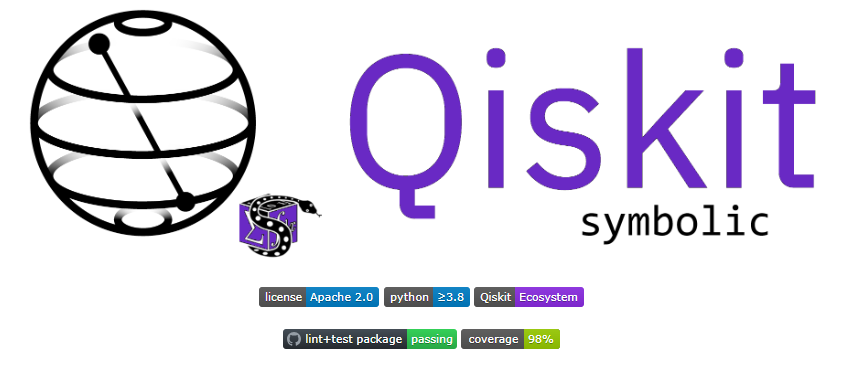

# `qiskit-symb` $\rightarrow$ https://github.com/SimoneGasperini/qiskit-symb

#### Python package to enable symbolic evaluation of quantum states and operators defined by parameterized quantum circuits in Qiskit
```
pip install qiskit-symb
```
It supports the symbolic representation of any parametric quantum `Statevector`, `DensityMatrix`, or `Operator` directly created from the Qiskit `QuantumCircuit` instance. It is based on the Python *sympy* library as the backend for symbolic expressions manipulation.

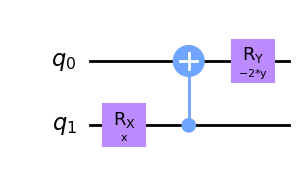

In [1]:
from qiskit.circuit import Parameter, QuantumCircuit

x = Parameter('x')
y = Parameter('y')

circuit = QuantumCircuit(2)
circuit.rx(x, 1)
circuit.cx(1, 0)
circuit.ry(-2*y, 0)

circuit.draw('mpl')

In [2]:
from qiskit.quantum_info import Operator

try:
    op = Operator(circuit) # not supported in qiskit-terra
except TypeError:
    print('TypeError: unbound parameters cannot be cast to float')

TypeError: unbound parameters cannot be cast to float


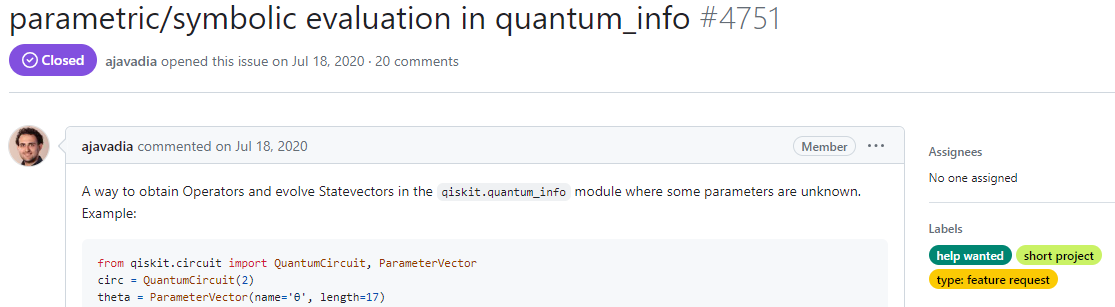

## Usage example

In [3]:
from qiskit_symb import Operator as SymbOperator

op = SymbOperator(circuit)
op.to_sympy()

Matrix([
[   cos(x/2)*cos(y),    sin(y)*cos(x/2), -I*sin(x/2)*cos(y), -I*sin(x/2)*sin(y)],
[  -sin(y)*cos(x/2),    cos(x/2)*cos(y),  I*sin(x/2)*sin(y), -I*sin(x/2)*cos(y)],
[-I*sin(x/2)*sin(y), -I*sin(x/2)*cos(y),    sin(y)*cos(x/2),    cos(x/2)*cos(y)],
[-I*sin(x/2)*cos(y),  I*sin(x/2)*sin(y),    cos(x/2)*cos(y),   -sin(y)*cos(x/2)]])

In [4]:
op1 = op.subs({y: 0})
op1.to_sympy()

Matrix([
[   cos(x/2),           0, -I*sin(x/2),           0],
[          0,    cos(x/2),           0, -I*sin(x/2)],
[          0, -I*sin(x/2),           0,    cos(x/2)],
[-I*sin(x/2),           0,    cos(x/2),           0]])

In [5]:
from numpy import pi

op2 = op.subs({x: 0, y: pi})
op2.to_sympy()

Matrix([
[-1,  0,  0,  0],
[ 0, -1,  0,  0],
[ 0,  0,  0, -1],
[ 0,  0, -1,  0]])

## Main features

- `from_label`, `from_circuit` methods for initializing the symbolic/parametric `Operator`, `Statevector`, `DensityMatrix`
- `transpose`, `conjugate`, `dagger` methods for manipulating the symbolic/parametric object
- support for all single-qubit and multi-qubit Qiskit gates, including multi-control and multi-target ⚠️
- support for any custom unitary gate (decomposed to Qiskit gates by using transpilation)
- method `subs` for (partial) parameters binding
- **method `to_lambda` to transform the symbolic/parametric object into a callable Python function**

⚠️`XXMinusYYGate`, `XXPlusYYGate`, `DCXGate` are not supported yet (work in progress, help wanted)

## Use-case example
Given a Parameterized Quantum Circuit (PQC) defined in Qiskit, the method `to_lambda` allows to generate a callable Python function whose arguments match the unbound parameters in the circuit.

When the PQC needs to be simulated many times with different values for the parameters (e.g. in Quantum Machine Learning applications), this feature can **significantly improve the full-statevector simulation performace**. Indeed, the symbolic evalutation of the circuit and the lambda generation take place only once and then the simulation only consists in calling multiple times the lambda-generated function passing a different parameters values at each iteration.

For PQCs with a *not-too-high* number of parameter, this **dramatically reduce the total execution time** compared to the time required for running all the simulations by using the standard Qiskit Aer simulator.

In [6]:
import numpy as np

# generate random data in [0, 2π]
num_samples = 1000
num_features = 3
data = np.random.rand(num_samples, num_features) * 2*np.pi
print(data)

[[3.6723128  0.22115971 0.91734989]
 [3.09750151 6.1632849  1.19679221]
 [4.93613671 5.83555372 0.0735059 ]
 ...
 [4.35985978 2.92530731 0.79018541]
 [2.69222294 5.24756199 1.45943278]
 [4.63875167 6.14255236 6.22549313]]


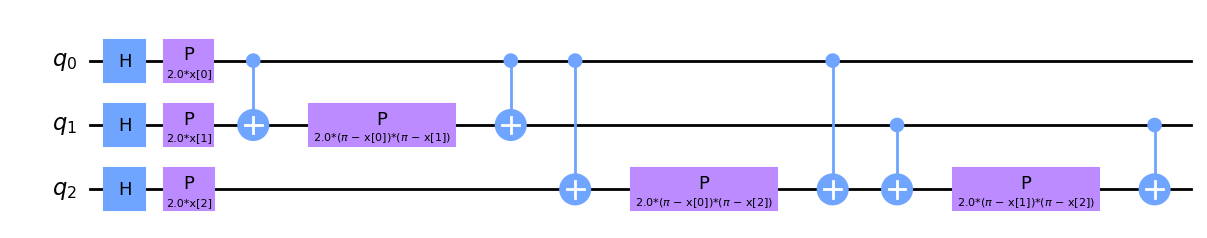

In [7]:
from qiskit.circuit.library import ZZFeatureMap

# create a data encoding PQC
pqc = ZZFeatureMap(num_features, reps=1).decompose()
pqc.draw('mpl')

In [8]:
from qiskit import Aer
from qiskit_symb import Statevector as SymbStatevector

def aer_simulator(pqc, data):
    simulator = Aer.get_backend('statevector_simulator')
    pars_dict = dict(zip(pqc.parameters, data.transpose()))
    job = simulator.run([pqc], parameter_binds=[pars_dict], shots=1)
    psi = job.result().results[-1].data.statevector
    return psi

def symb_simulator(pqc, data):
    circuit = SymbStatevector(pqc).to_lambda()
    for x in data:
        psi = circuit(*x)
    return psi

In [9]:
%%time
psi_1 = aer_simulator(pqc=pqc, data=data)

CPU times: total: 6.69 s
Wall time: 6.78 s


In [10]:
print(psi_1)

Statevector([ 0.35355339+0.j        , -0.25213432+0.2478473j ,
             -0.17270361+0.30850197j,  0.20295135-0.28950086j,
             -0.28226548+0.21289951j,  0.17841365-0.30523527j,
              0.18316653-0.30240705j, -0.30253004+0.18296332j],
            dims=(2, 2, 2))


In [11]:
%%time
psi_2 = symb_simulator(pqc=pqc, data=data)

CPU times: total: 172 ms
Wall time: 162 ms


In [12]:
print(psi_2)

[[ 0.35355339+0.j        ]
 [-0.25213432+0.2478473j ]
 [-0.17270361+0.30850197j]
 [ 0.20295135-0.28950086j]
 [-0.28226548+0.21289951j]
 [ 0.17841365-0.30523527j]
 [ 0.18316653-0.30240705j]
 [-0.30253004+0.18296332j]]


In [13]:
numpy_arr_1 = psi_1.data
numpy_arr_2 = psi_2[:, 0]
print(np.allclose(numpy_arr_1, numpy_arr_2))

True


## Future developments
- optimize symbolic linear algebra for circuit layers with parallel gates
- use higher-level optimization for circuit transpilation before *sympy* conversion
***
- support interoperability between different symbolic/parametric objects (e.g. `Statevector.evolve(Operator)`)
- implement a *sympy*-based statevector simulator to run PQCs (e.g. `simulator = get_backend('symbolic_simulator')`)
- enable the creation of Qiskit PQCs from symbolic/parametric unitary *sympy* matrices defining quantum operators
***

In [14]:
import qiskit.tools.jupyter

%qiskit_version_table